In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [54]:
CLOSE_MOUTH_PATH = 'data/sa1/001'
OPEN_MOUTH_PATH = 'data/sa1/027'

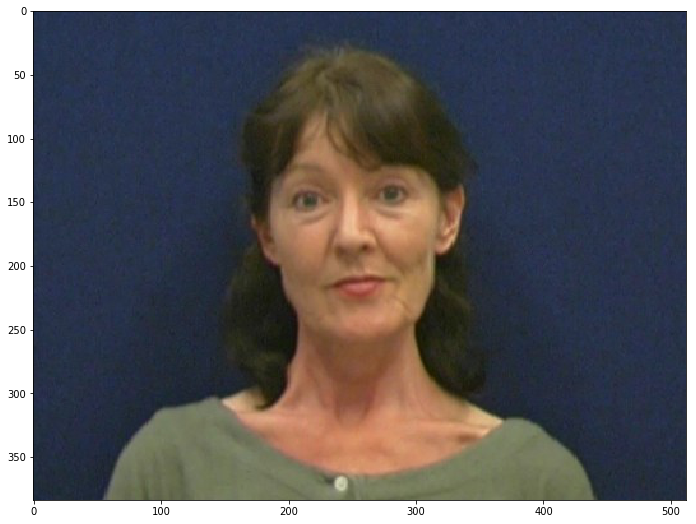

In [55]:
img = cv2.imread(CLOSE_MOUTH_PATH)
plt.figure(figsize=(12, 9))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

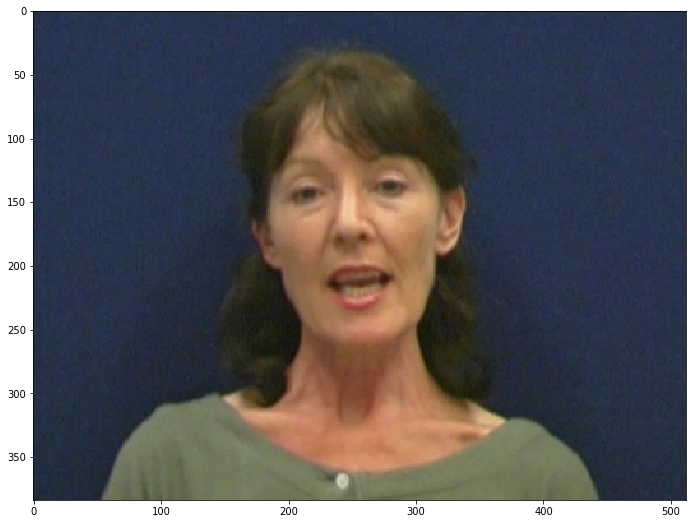

In [56]:
img = cv2.imread(OPEN_MOUTH_PATH)
plt.figure(figsize=(12, 9))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [4]:
def get_landmarks(path):
    numbers = None
    with open(path) as f:
        numbers = np.array(list(map(lambda x: list(map(float, x.strip('()\n').split(','))), f.readlines()))).flatten()
    return numbers

In [5]:
# Check if a point is inside a rectangle
def rect_contains(rect, point) :
    if point[0] < rect[0] :
        return False
    elif point[1] < rect[1] :
        return False
    elif point[0] > rect[2] :
        return False
    elif point[1] > rect[3] :
        return False
    return True

In [48]:
def triangulation(path):
    raw_data = get_landmarks(path+"_sol")
    points = []
    for i in range(len(raw_data)//2):
        points.append((int(raw_data[2*i]), int(raw_data[2*i+1])))

    img = cv2.imread(path)

    rect = (0, 0, img.shape[1], img.shape[0])
    subdiv  = cv2.Subdiv2D(rect)
    for p in points :
        cv2.circle(img, p, 2, (255,0,0), -1)
        subdiv.insert(p)

    tri = []
    for t in subdiv.getTriangleList():
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])

        if rect_contains(rect, pt1) and rect_contains(rect, pt2) and rect_contains(rect, pt3):
            pt1idx = points.index(pt1)
            pt2idx = points.index(pt2)
            pt3idx = points.index(pt3)
            tri.append((pt1idx, pt2idx, pt3idx))
            cv2.line(img, pt1, pt2, (255, 255, 255))
            cv2.line(img, pt2, pt3, (255, 255, 255))
            cv2.line(img, pt3, pt1, (255, 255, 255))

    plt.figure(figsize=(12, 9))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    
    return tri

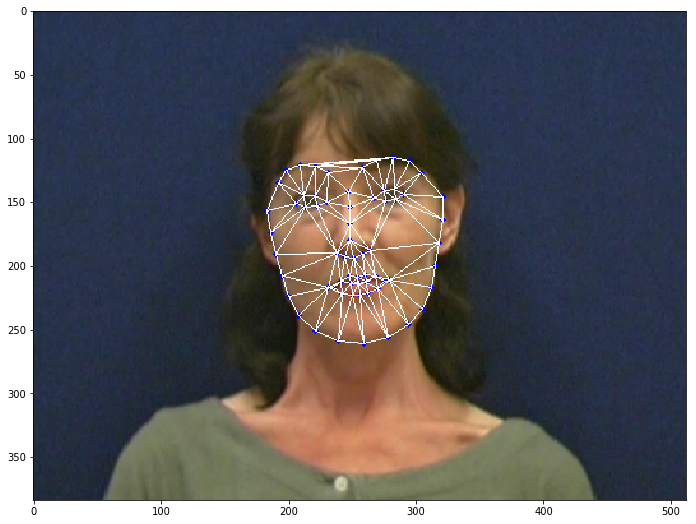

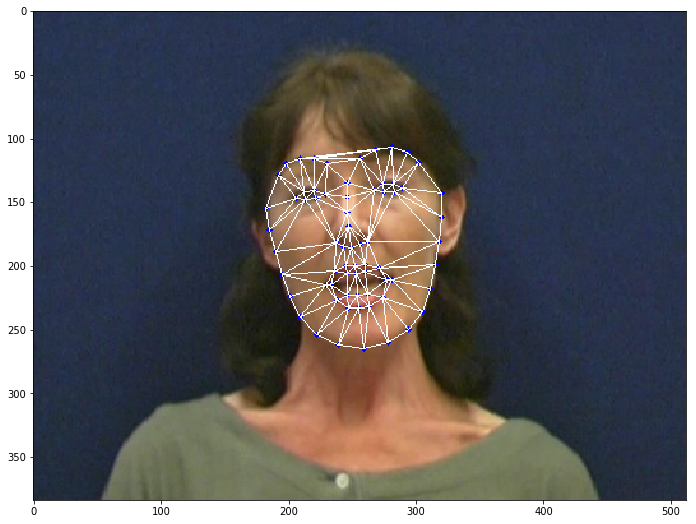

In [57]:
close_mouth_mesh = triangulation(CLOSE_MOUTH_PATH)
open_mouth_mesh = triangulation(OPEN_MOUTH_PATH)

In [18]:
def loadRGBA(path):
    img = cv2.imread(path, -1)
    # if only has rgb, extend it to rgba
    if img.shape[2] == 3:
        rc, gc, bc = cv2.split(img)
        ac = np.ones(bc.shape, dtype=bc.dtype) * 255
        img = cv2.merge((rc, gc, bc, ac))
    return img

In [29]:
def getMask(img, roi_corners):
    mask = np.zeros(img.shape, dtype=np.uint8)
    ignore_mask_color = (255,255, 255,255)
    cv2.fillPoly(mask, roi_corners, ignore_mask_color)
    return mask

In [38]:
def pasteimg(srcimg, dstimg, srcTri, dstTri):
    mask = getMask(srcimg, np.array(srcTri, dtype=np.int32))

    M = cv2.getAffineTransform(srcTri, dstTri)
    mask = cv2.warpAffine(mask, M, (img.shape[1], img.shape[0]))
    warpped_img = cv2.warpAffine(srcimg, M, (img.shape[1], img.shape[0]))
    
    for r in range(mask.shape[0]):
        for c in range(mask.shape[1]):
            if not (mask[r, c] == np.float32([0, 0, 0, 0])).all():
                dstimg[r, c] = warpped_img[r, c]

    return dstimg

In [44]:
def emptyImg(img):
    return np.zeros(img.shape, dtype=np.uint8)

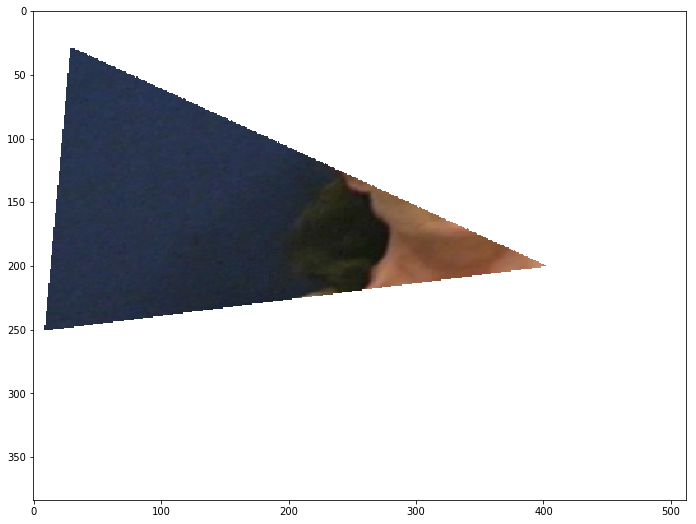

In [45]:
src = loadRGBA('data/sa1/001')
dst = loadRGBA('data/sa1/001')
dst = emptyImg(src)

srcTri = np.float32([[(10,10), (300,300), (10,300)]])
dstTri = np.float32([[(30,30), (400,200), (10,250)]])

dst = pasteimg(src, dst, srcTri, dstTri)

plt.figure(figsize=(12, 9))
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGRA2RGBA))
plt.show()